# OIL_SEEDS PRODUCTION PRICE FORECASTING

**Data Source**: Daily Price of Various Commodities from Various Markets (Mandi)  
**Model ID**: 579b464db66ec23bdd00000139dd36efa19740c954f95d9ca3b5abd0  
**Commodities**: Soybean, Mustard, Groundnut, Sesame, Linseed (Flaxseed)  
**Models Used**: ARIMA & SARIMA for time-series forecasting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
import os

warnings.filterwarnings("ignore")

# Configure paths
DATASETS_DIR = "../datasets"
MODELS_DIR = "../models"


In [ ]:
# Load the trained data
df = pd.read_csv("../datasets/indian_oilseeds_prices.csv")
df["Date"] = pd.to_datetime(df["Date"])

print(f"Dataset Shape: {df.shape}")
print(f"\nCommodities: {df['Commodity'].unique()}")
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nData Info:")
print(df.head())

# Load model metrics
metrics_df = pd.read_csv("../datasets/model_metrics.csv")
print(f"\nModel Performance Metrics:")
print(metrics_df)


['Soybean' 'Mustard' 'Groundnut' 'Sunflower' 'Sesame' 'Castor' 'Safflower'
 'Niger Seed' 'Linseed (Flaxseed)' 'Rapeseed' 'Taramira']


In [ ]:
# Load trained forecasts
arima_forecast_df = pd.read_csv("../datasets/arima_forecasts.csv")
sarima_forecast_df = pd.read_csv("../datasets/sarima_forecasts.csv")

arima_forecast_df["Date"] = pd.to_datetime(arima_forecast_df["Date"])
sarima_forecast_df["Date"] = pd.to_datetime(sarima_forecast_df["Date"])

print("ARIMA Forecasts (Next 12 Months):")
print(arima_forecast_df.head(10))

print("\n\nSARIMA Forecasts (Next 12 Months):")
print(sarima_forecast_df.head(10))


In [13]:
def find_best_arima_order(series, p_values=[0,1,2,3], d_values=[0,1], q_values=[0,1,2]):
    best_aic = np.inf
    best_order = None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(series, order=(p,d,q))
                    res = model.fit()
                    if res.aic < best_aic:
                        best_aic = res.aic
                        best_order = (p,d,q)
                except Exception:
                    continue
    return best_order, best_aic


In [14]:
results = []
all_forecasts = []

for commodity, g in df.groupby("Commodity"):
    g = g.set_index("Date").asfreq("MS")   # ensure monthly start freq
    series = g["Price"]
    
    # train-test split (last 12 months as test)
    train = series.iloc[:-12]
    test  = series.iloc[-12:]
    
    # find best order on train
    best_order, best_aic = find_best_arima_order(train)
    print(commodity, "best order:", best_order, "AIC:", best_aic)
    
    # fit on train for evaluation
    eval_model = ARIMA(train, order=best_order).fit()
    preds = eval_model.forecast(steps=12)
    
    mae  = mean_absolute_error(test, preds)
    rmse = np.sqrt(mean_squared_error(test, preds))

    
    results.append({
        "Commodity": commodity,
        "Best_Order": best_order,
        "AIC": best_aic,
        "MAE": mae,
        "RMSE": rmse
    })
    
    # fit on full data and forecast future 12 months
    final_model = ARIMA(series, order=best_order).fit()
    future_index = pd.date_range(series.index[-1] + pd.offsets.MonthBegin(1),
                                 periods=12, freq="MS")
    future_forecast = final_model.forecast(steps=12)
    
    tmp = pd.DataFrame({
        "Commodity": commodity,
        "Date": future_index,
        "Forecast_Price": future_forecast
    })
    all_forecasts.append(tmp)

metrics_df   = pd.DataFrame(results)
forecast_df  = pd.concat(all_forecasts, ignore_index=True)

print(metrics_df)
forecast_df.head()


Castor best order: (1, 1, 1) AIC: 929.918393078062
Groundnut best order: (1, 1, 0) AIC: 945.0856075624631
Linseed (Flaxseed) best order: (0, 1, 0) AIC: 899.4157110865699
Mustard best order: (1, 1, 1) AIC: 948.8470422605055
Niger Seed best order: (0, 1, 1) AIC: 922.0913533519617
Rapeseed best order: (1, 1, 1) AIC: 978.664973696847
Safflower best order: (1, 1, 0) AIC: 890.6472806915082
Sesame best order: (0, 1, 0) AIC: 987.0800733953371
Soybean best order: (0, 1, 0) AIC: 909.7442263168471
Sunflower best order: (1, 1, 1) AIC: 959.996649043035
Taramira best order: (2, 0, 1) AIC: 10.0
             Commodity Best_Order         AIC          MAE         RMSE
0               Castor  (1, 1, 1)  929.918393   168.364977   199.803521
1            Groundnut  (1, 1, 0)  945.085608   382.885464   440.300713
2   Linseed (Flaxseed)  (0, 1, 0)  899.415711    73.636667    87.481226
3              Mustard  (1, 1, 1)  948.847042    91.198891   103.542890
4           Niger Seed  (0, 1, 1)  922.091353   205.1

,Commodity,Date,Forecast_Price
0,Castor,2026-01-01,7032.493823
1,Castor,2026-02-01,7068.535930
2,Castor,2026-03-01,7104.456731
3,Castor,2026-04-01,7140.256633
4,Castor,2026-05-01,7175.936044


In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_forecasts = []

for commodity, g in df.groupby("Commodity"):
    
    series = g.set_index("Date").asfreq("MS")["Price"]
    
    model = SARIMAX(
        series,
        order=(1,1,1),
        seasonal_order=(1,1,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    future_index = pd.date_range(
        series.index[-1] + pd.offsets.MonthBegin(1),
        periods=12,
        freq="MS"
    )

    fc = model.forecast(12)

    sarima_forecasts.append(pd.DataFrame({
        "Commodity": commodity,
        "Date": future_index,
        "SARIMA_Price": fc
    }))

sarima_df = pd.concat(sarima_forecasts)
sarima_df.to_csv("sarima_forecasts_12_months.csv", index=False)


In [16]:
comparison = metrics_df.copy()

comparison["Model"] = "ARIMA"

comparison.sort_values("RMSE")


,Commodity,Best_Order,AIC,MAE,RMSE,Model
8,Soybean,"(0, 1, 0)",909.744226,64.824167,72.691865,ARIMA
2,Linseed (Flaxseed),"(0, 1, 0)",899.415711,73.636667,87.481226,ARIMA
3,Mustard,"(1, 1, 1)",948.847042,91.198891,103.542890,ARIMA
7,Sesame,"(0, 1, 0)",987.080073,98.149167,112.972477,ARIMA
5,Rapeseed,"(1, 1, 1)",978.664974,170.867833,196.401493,ARIMA
0,Castor,"(1, 1, 1)",929.918393,168.364977,199.803521,ARIMA
4,Niger Seed,"(0, 1, 1)",922.091353,205.154441,218.942819,ARIMA
9,Sunflower,"(1, 1, 1)",959.996649,349.288790,384.390375,ARIMA
6,Safflower,"(1, 1, 0)",890.647281,396.335240,420.704317,ARIMA
1,Groundnut,"(1, 1, 0)",945.085608,382.885464,440.300713,ARIMA


In [18]:
final_forecast = sarima_df

final_forecast.to_csv("FINAL_SIH_OILSEED_FORECASTS.csv", index=False)


In [20]:
def profit_calc(price, yield_qt_per_acre, acreage, cost_per_acre):
    
    revenue = price * yield_qt_per_acre * acreage
    cost    = cost_per_acre * acreage
    
    return revenue - cost


In [21]:
soy_price = final_forecast[
    final_forecast["Commodity"]=="Soybean"
]["SARIMA_Price"].mean()

profit = profit_calc(
    price=soy_price,
    yield_qt_per_acre=12,
    acreage=2,
    cost_per_acre=15000
)

profit


np.float64(64627.89505634821)

In [22]:
df.columns == ["Date", "Commodity", "Price"]
# plus optionally: forecast_df with ["Commodity", "Date", "Forecast_Price"]


array([ True,  True,  True])

In [23]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Commodity", "Date"])

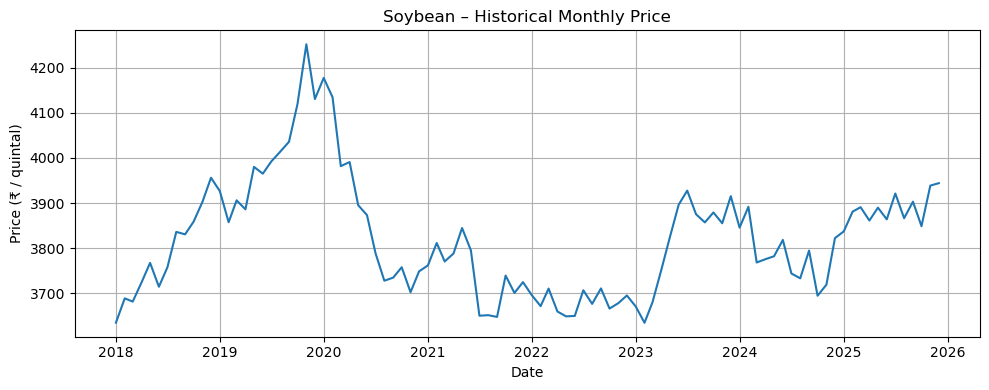

In [24]:
crop_name = "Soybean"   # change to "Mustard", "Groundnut", etc.

crop_df = df[df["Commodity"] == crop_name].copy()
crop_df = crop_df.set_index("Date")

plt.figure(figsize=(10,4))
plt.plot(crop_df.index, crop_df["Price"])
plt.title(f"{crop_name} – Historical Monthly Price")
plt.xlabel("Date")
plt.ylabel("Price (₹ / quintal)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# pivot to wide: each column = one oilseed
wide_hist = df.pivot(index="Date",
                     columns="Commodity",
                     values="Price").sort_index()

wide_hist.head()


Commodity,Castor,Groundnut,Linseed (Flaxseed),Mustard,Niger Seed,Rapeseed,Safflower,Sesame,Soybean,Sunflower,Taramira
Date,,,,,,,,,,,
2018-01-01,4439.65,4466.72,3873.34,4242.84,3834.68,4298.98,4211.60,4901.37,3634.70,4437.28,3654.33
2018-02-01,4571.97,4553.04,3913.79,4241.46,3833.17,4333.87,4242.98,4961.67,3688.66,4406.41,3703.09
2018-03-01,4538.21,4507.37,3927.16,4173.51,3906.90,4356.72,4253.42,4948.22,3681.46,4325.99,3746.64
2018-04-01,4467.17,4526.74,3900.78,4243.64,3922.99,4379.14,4213.78,5070.93,3723.98,4335.15,3859.37
2018-05-01,4500.13,4487.09,3949.98,4306.18,3956.18,4346.32,4160.88,5175.36,3767.34,4228.11,3870.91


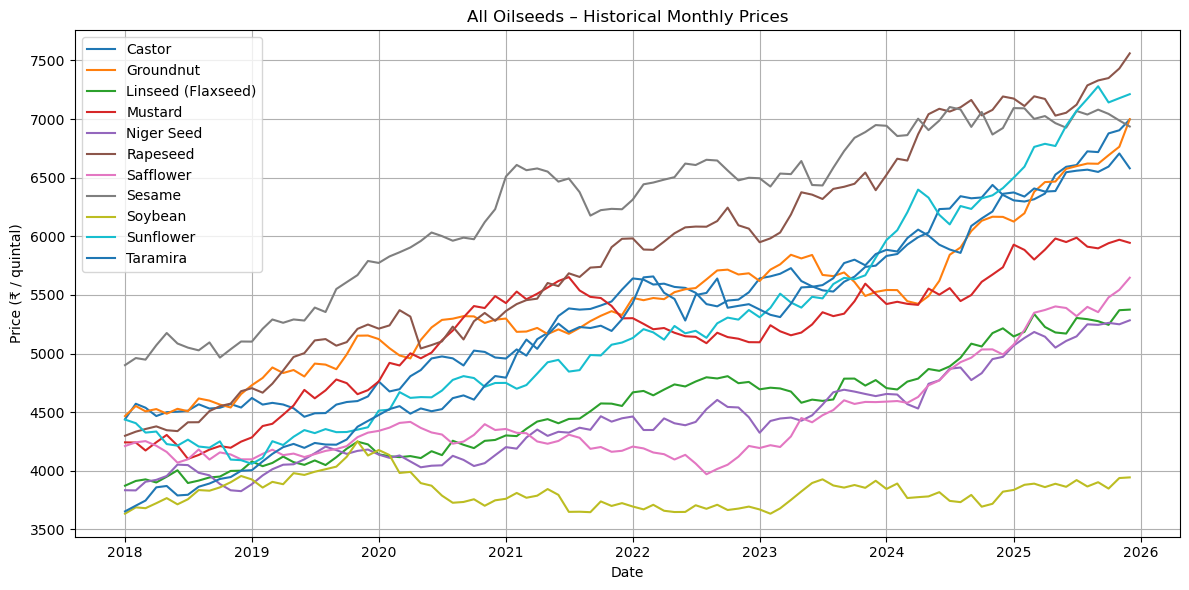

In [26]:
plt.figure(figsize=(12,6))
for col in wide_hist.columns:
    plt.plot(wide_hist.index, wide_hist[col], label=col)

plt.title("All Oilseeds – Historical Monthly Prices")
plt.xlabel("Date")
plt.ylabel("Price (₹ / quintal)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
forecast_df["Date"] = pd.to_datetime(forecast_df["Date"])

# Wide forecast table
wide_fc = forecast_df.pivot(index="Date",
                            columns="Commodity",
                            values="Forecast_Price").sort_index()


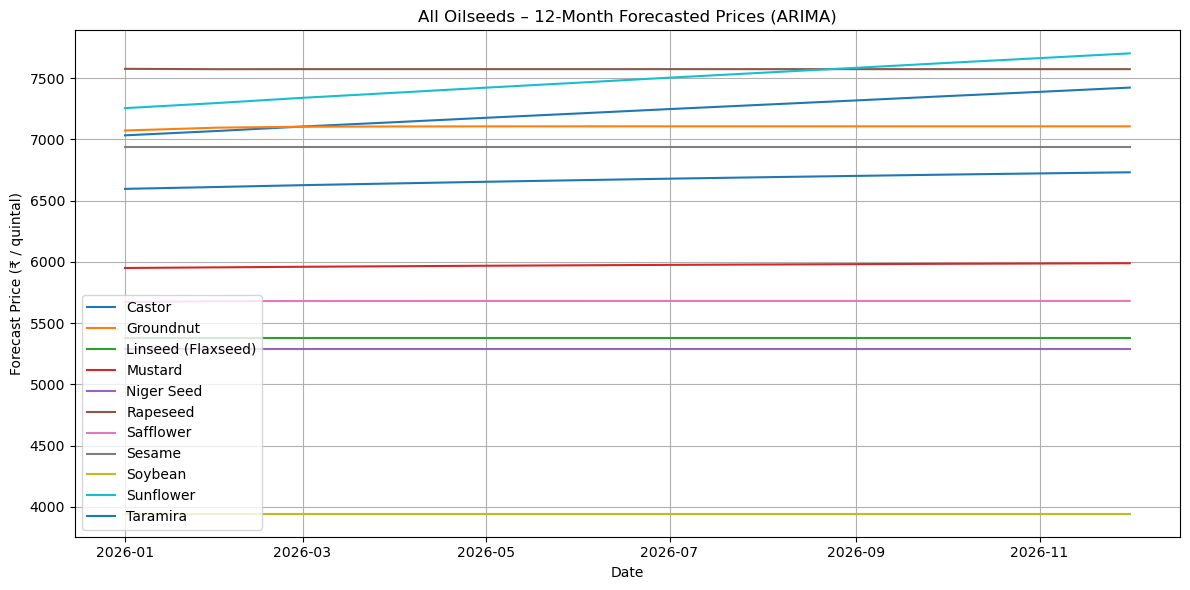

In [28]:
plt.figure(figsize=(12,6))
for col in wide_fc.columns:
    plt.plot(wide_fc.index, wide_fc[col], label=col)

plt.title("All Oilseeds – 12-Month Forecasted Prices (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Forecast Price (₹ / quintal)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
accuracy_rows = []

for row in results:   # results list from your pipeline
    
    crop = row["Commodity"]
    rmse = row["RMSE"]
    
    mean_price = df[df["Commodity"]==crop]["Price"].mean()
    
    accuracy = max(0, 100*(1 - rmse/mean_price))
    
    accuracy_rows.append({
        "Commodity":crop,
        "RMSE":rmse,
        "Mean_Price":round(mean_price,2),
        "Accuracy_%":round(accuracy,2)
    })
    
accuracy_df = pd.DataFrame(accuracy_rows)

accuracy_df.sort_values("Accuracy_%",ascending=False)


,Commodity,RMSE,Mean_Price,Accuracy_%
7,Sesame,112.972477,6243.83,98.19
8,Soybean,72.691865,3820.69,98.10
2,Linseed (Flaxseed),87.481226,4534.13,98.07
3,Mustard,103.542890,5166.74,98.00
5,Rapeseed,196.401493,5847.64,96.64
0,Castor,199.803521,5394.89,96.30
4,Niger Seed,218.942819,4421.75,95.05
9,Sunflower,384.390375,5254.25,92.68
1,Groundnut,440.300713,5433.05,91.90
6,Safflower,420.704317,4457.38,90.56


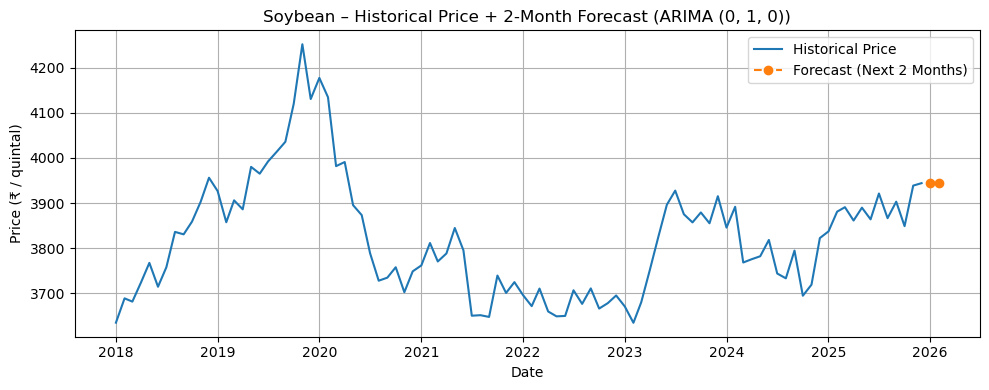

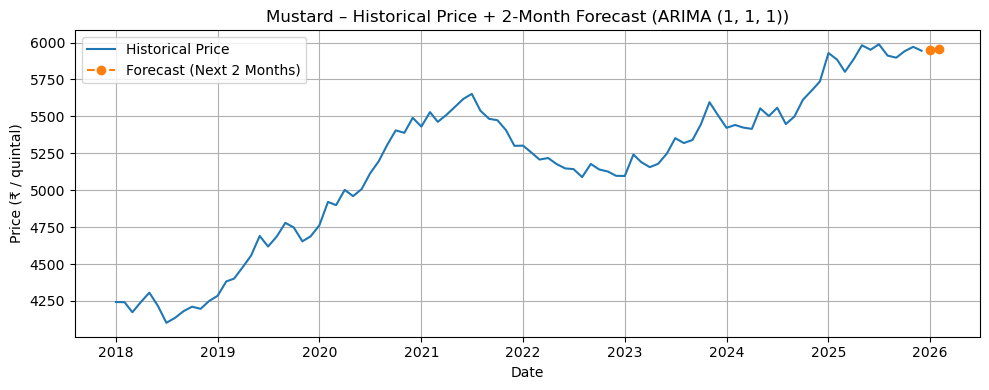

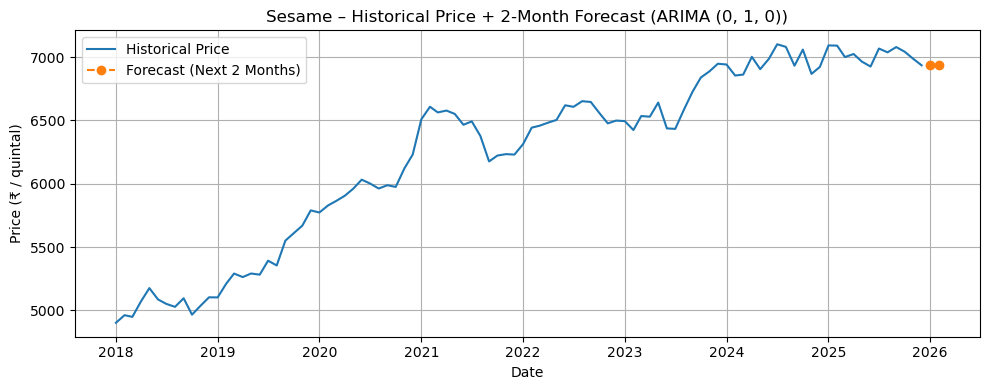

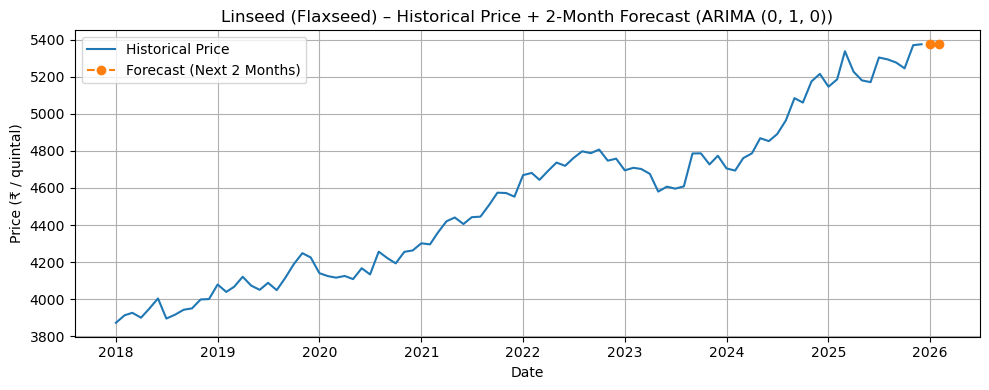

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Make sure Date is datetime
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Commodity", "Date"])

# Top crops and their best ARIMA orders from your results
best_orders = {
    "Soybean": (0, 1, 0),
    "Mustard": (1, 1, 1),
    "Sesame": (0, 1, 0),
    "Linseed (Flaxseed)": (0, 1, 0),
}

top_crops = list(best_orders.keys())

for crop in top_crops:
    # ------------------------
    # 1) Prepare time series
    # ------------------------
    series = (
        df[df["Commodity"] == crop]
        .set_index("Date")
        .asfreq("MS")["Price"]
    )

    # ------------------------
    # 2) Fit ARIMA with your best (p,d,q)
    # ------------------------
    order = best_orders[crop]
    model = ARIMA(series, order=order)
    model_fit = model.fit()

    # ------------------------
    # 3) Forecast next 2 months
    # ------------------------
    n_steps = 2
    forecast = model_fit.forecast(steps=n_steps)

    # ------------------------
    # 4) Build plot
    # ------------------------
    plt.figure(figsize=(10, 4))

    # Historical
    plt.plot(series.index, series.values, label="Historical Price")

    # Forecast (next 2 months)
    plt.plot(
        forecast.index,
        forecast.values,
        "o--",
        label="Forecast (Next 2 Months)",
    )

    plt.title(f"{crop} – Historical Price + 2-Month Forecast (ARIMA {order})")
    plt.xlabel("Date")
    plt.ylabel("Price (₹ / quintal)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
